In [1]:
!pip install -U bnlp_toolkit

In [2]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
from bnlp import BasicTokenizer
from bnlp import SentencepieceTokenizer
from bnlp import BengaliWord2Vec
from bnlp import NLTKTokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import precision_recall_fscore_support


In [3]:
dataset = pd.read_csv("C:\\Users\\User\\Desktop\\Spring'24\\CSE465 Project\\Dataset\\train.csv")
df = dataset

# Cleaning


In [4]:
def clean_text(text):
    # Emoji removal pattern covering various emoji ranges
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    # Remove emojis
    text = emoji_pattern.sub(r'', text)
    # Remove English characters & numbers
    text = re.sub(r'[A-Za-z0-9]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove punctuation
    text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]০১২৩৪৫৬৭৮৯', '', text)
    punctuations = '''`|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    # Create a character class to remove specified characters
    regex_pattern = '[' + re.escape(punctuations) + ']'
    text = re.sub(regex_pattern, '', text)


    return text

df['sentence'] = df['sentence'].apply(clean_text)
df = df.drop(columns=['type','hate speech'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40224 entries, 0 to 40223
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  40224 non-null  object
 1   target    19324 non-null  object
dtypes: object(2)
memory usage: 628.6+ KB


In [6]:
df.isnull().sum() # Null values mean the corresponding sentence is not hate speech

sentence        0
target      20900
dtype: int64

In [7]:
df['target'].fillna('0', inplace=True) # Replace null values with 0



In [8]:
df.isnull().sum() 


sentence    0
target      0
dtype: int64

In [9]:
type_unique = df['target'].nunique()
type_unique

12

In [10]:
distinct_classes = df['target'].unique()
distinct_classes


array(['ind', 'female', 'male', 'group', 'male_female', 'ind_female',
       'male_group', 'female_group', 'ind_group', 'male_female_group',
       'ind_male', '0'], dtype=object)

In [11]:
class_mapping = {
    '0': 0,
    'ind': 1,
    'female': 2,
    'male': 3,
    'group': 4,
    'male_female': 5,
    'ind_female': 6,
    'male_group': 7,
    'female_group': 8,
    'ind_group': 9,
    'male_female_group': 10,
    'ind_male': 11,

}

# Apply the mapping to the 'type' column
df['encoded_target'] = df['target'].map(class_mapping)

# Verify the encoding
df[['target', 'encoded_target']].head(50)

,target,encoded_target
0,ind,1
1,ind,1
2,ind,1
3,female,2
4,male,3
5,female,2
6,ind,1
7,ind,1
8,ind,1
9,group,4


In [12]:
distinct_classes = df['encoded_target'].unique()
distinct_classes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0], dtype=int64)

# Tokenization

In [13]:
basic_tokenizer = BasicTokenizer()

df['sentence'] = df['sentence'].apply(basic_tokenizer.tokenize)
df

,sentence,target,encoded_target
0,"[ঐ, ইন্দুর, তোই, মরছ, নাই]",ind,1
1,"[গেবনের, শেষে, আইসা, আপনার, মুখোশ, টা, খুলছে, ...",ind,1
2,"[মুরগি, চোরের, পাছায়, ডুকবি, আর, মারবি]",ind,1
3,"[কোটির, চোদা, খাওয়া, শেষে, এখন, কোটির, চোদা, খ...",female,2
4,"[য়, মীর, জাফরের, মুখে, মুতে, দে]",male,3
...,...,...,...
40219,"[গানটা, চালু, করে, ওয়াস, রুমে, গিয়েছিলাম, এসে,...",0,0
40220,"[হালকার, উপজেলা, ঝাপসা]",0,0
40221,[],0,0
40222,"[পুরাই, আগুনের, গুলা]",0,0


# Word2vec

In [14]:
pf = df.copy()
#pf.to_csv('train_processed(target).csv', index=False)

In [15]:
from bnlp import Word2VecTraining

trainer = Word2VecTraining()

sentences = pf['sentence'].tolist()

model_name = "hsw2v.model"
vector_name = "hsw2v.vector"

In [16]:
trainer.train(sentences, model_name, vector_name, epochs=100)


training started.......
please wait.....it will take time according to your data size and computation capability
train completed successfully
trianing loss: 17622736.0
model and vector saving...
model and vector saved as hsw2v.model and hsw2v.vector


Transform into word vectors

In [17]:
own_model_path = "hsw2v.model"
bwv = BengaliWord2Vec(model_path=own_model_path)
def sentence_to_vectors(sentence_tokens):

    vectors = []
    for word in sentence_tokens:
        try:
            vector = bwv.get_word_vector(word)
            vectors.append(vector)
        except KeyError:
            # Ignore words that are not in the vocabulary
            # Or handle with a zero vector if needed:
            # vector = np.zeros(bwv.get_word_vector("গ্রাম").shape)
            # vectors.append(vector)
            continue
    return vectors


In [18]:
pf['vectors'] = pf['sentence'].apply(sentence_to_vectors)
pf

,sentence,target,encoded_target,vectors
0,"[ঐ, ইন্দুর, তোই, মরছ, নাই]",ind,1,"[[0.54311496, 1.0851295, 0.82299, -2.579656, -..."
1,"[গেবনের, শেষে, আইসা, আপনার, মুখোশ, টা, খুলছে, ...",ind,1,"[[-0.5713225, -0.33004153, -0.13594042, -1.105..."
2,"[মুরগি, চোরের, পাছায়, ডুকবি, আর, মারবি]",ind,1,"[[0.27445203, -0.7889489, -1.334128, 1.3176531..."
3,"[কোটির, চোদা, খাওয়া, শেষে, এখন, কোটির, চোদা, খ...",female,2,"[[0.6323435, 0.25632992, 0.7669722, 0.4142836,..."
4,"[য়, মীর, জাফরের, মুখে, মুতে, দে]",male,3,"[[-0.6938862, 0.9031493, -1.8036468, 2.0337799..."
...,...,...,...,...
40219,"[গানটা, চালু, করে, ওয়াস, রুমে, গিয়েছিলাম, এসে,...",0,0,"[[-0.77782255, 0.7982964, 0.8165977, -0.682045..."
40220,"[হালকার, উপজেলা, ঝাপসা]",0,0,[]
40221,[],0,0,[]
40222,"[পুরাই, আগুনের, গুলা]",0,0,"[[-1.5563018, 5.508676, 0.6655884, -3.306936, ..."


# Training & evaluation loops

In [19]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0



In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

def train_ES(model, train_loader, val_loader, num_epochs, lr, early_stopping, lr_schduler, optimize):
    
    train_losses = []
    val_losses = []
    
    if early_stopping:
        early_stopper = EarlyStopping(patience=5, min_delta=0.01)
        print('Using Early stopping...')
        
    criterion = nn.CrossEntropyLoss()
    
    if optimize == 1:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        print('Using SGD as optimizer...')
    elif optimize == 2: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        print('Using Adam as optimizer...')
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        print('Using AdamW as optimizer...')
        
    if lr_schduler:
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)
        print('Using Learning Rate Scheduler...')
    
    print('Starting training...')
    for epoch in range(num_epochs):
        model.train()
        for vectors, labels in train_loader:
            vectors, labels = vectors.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(vectors)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for vectors, labels in val_loader:
                vectors, labels = vectors.to(device), labels.to(device)
                outputs = model(vectors)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')
        
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        # Update the learning rate
        if lr_schduler:
            scheduler.step(val_loss)

        # Early stopping check
        if early_stopping:
            early_stopper(val_loss)
            if early_stopper.early_stop:
                print("Terminated due to no validation improvement(Early stopping applied)")
                break
    
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.plot(epochs, val_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [21]:
def evaluate_model(model, dataloader):    
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for vectors, labels in dataloader:
            vectors, labels = vectors.to(device), labels.to(device)
            outputs = model(vectors)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted') 
    precision *= 100
    recall *= 100
    f1 *= 100
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    
    return accuracy, precision, recall, f1

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set data loaders

In [23]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split

class SentenceDataset(Dataset):
    def __init__(self, vectors, labels):
        self.vectors = [torch.tensor(v, dtype=torch.float32, device=device) for v in vectors if len(v) > 0]  # Ensure non-empty
        self.labels = torch.tensor(labels, dtype=torch.long, device=device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.vectors[idx], self.labels[idx]

def collate_fn(batch):
    # Separate source data and labels
    vectors, labels = zip(*batch)

    # Pad the sequences for each batch separately
    vectors_padded = pad_sequence(vectors, batch_first=True).to(device)

    # Convert labels to a tensor
    labels = torch.tensor(labels, dtype=torch.long, device=device)

    return vectors_padded, labels

# If there are empty vectors, replace them with a zero vector of the same size as others
model_vector_size = 100
non_empty_vectors = [v if len(v) > 0 else [np.zeros(model_vector_size)] for v in pf['vectors']]
labels = pf['encoded_target'].tolist()  

# Creating padded sequences
padded_vectors = pad_sequence([torch.tensor(v) for v in non_empty_vectors], batch_first=True)

# Create dataset and data loader

dataset = SentenceDataset(non_empty_vectors, labels)

# Total number of data points
total_count = len(dataset)

# Determine the sizes for training and validation sets
train_count = int(0.8 * total_count)
val_count = total_count - train_count

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_count, val_count])
batch_size = 32

# Train DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)



In [24]:
padded_vectors.size(2)  # vector size


100

# Models

LSTM

In [25]:
import torch.nn.init as init
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Initialize the weights of the LSTM anda fully-connected layers
        init.xavier_uniform_(self.lstm.weight_ih_l0)
        init.xavier_uniform_(self.lstm.weight_hh_l0)
        init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        output, _ = self.lstm(x)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        return self.fc(last_output)

input_dim = padded_vectors.size(2)  # vector size
hidden_dim = 128
labels_tensor = torch.tensor(labels, dtype=torch.long, device=device)
output_dim = len(torch.unique(labels_tensor))
num_layers = 4


#model_LSTM = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5).to(device)

BI-lstm

In [26]:
import torch.nn as nn
import torch.nn.init as init

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiplied by 2 for bidirectional

        # Initialize the weights of the LSTM and fully-connected layers
        init.xavier_uniform_(self.bilstm.weight_ih_l0)
        init.xavier_uniform_(self.bilstm.weight_hh_l0)
        init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        output, _ = self.bilstm(x)
        last_output = torch.cat((output[:, -1, :hidden_dim], output[:, 0, hidden_dim:]), dim=1)
        last_output = self.dropout(last_output)  # Apply dropout
        return self.fc(last_output)

# Assuming the input dimension of the vectors and output_dim (number of classes)
input_dim = padded_vectors.size(2)  # vector size
hidden_dim = 128  # You can tune this
labels_tensor = torch.tensor(labels, dtype=torch.long, device=device)
output_dim = len(torch.unique(labels_tensor))  # Adjust based on your problem
num_layers = 4

#model_BILSTM = BiLSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.3).to(device)

GRU

In [27]:
import torch.nn as nn
import torch.nn.init as init

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Initialize the weights of the GRU and fully-connected layers
        init.xavier_uniform_(self.fc.weight)
        for layer in range(num_layers):
            init.xavier_uniform_(getattr(self.gru, f'weight_ih_l{layer}'))
            init.xavier_uniform_(getattr(self.gru, f'weight_hh_l{layer}'))

    def forward(self, x):
        output, _ = self.gru(x)
        last_output = output[:, -1, :]  # Take the output from the last timestep
        last_output = self.dropout(last_output)
        return self.fc(last_output)

# Model instantiation
input_dim = padded_vectors.size(2)  # vector size
hidden_dim = 128  # You can tune this
labels_tensor = torch.tensor(labels, dtype=torch.long, device=device)
output_dim = len(torch.unique(labels_tensor))  # Adjust based on your problem
num_layers = 4

#model_GRU = GRUModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.3).to(device)


# Run models

LSTM

Running LSTM model
Using Early stopping...
Using Adam as optimizer...
Using Learning Rate Scheduler...
Starting training...
Epoch [1/30], Training Loss: 1.4004, Validation Loss: 1.3213
Epoch [2/30], Training Loss: 0.9592, Validation Loss: 1.1520
Epoch [3/30], Training Loss: 0.9632, Validation Loss: 1.0045
Epoch [4/30], Training Loss: 0.8380, Validation Loss: 0.9216
Epoch [5/30], Training Loss: 0.7425, Validation Loss: 0.8008
Epoch [6/30], Training Loss: 0.4147, Validation Loss: 0.7538
Epoch [7/30], Training Loss: 0.4307, Validation Loss: 0.7271
Epoch [8/30], Training Loss: 0.3879, Validation Loss: 0.7066
Epoch [9/30], Training Loss: 0.5098, Validation Loss: 0.7198
Epoch [10/30], Training Loss: 0.3872, Validation Loss: 0.6925
Epoch [11/30], Training Loss: 0.2578, Validation Loss: 0.7277
Epoch [12/30], Training Loss: 0.3257, Validation Loss: 0.7250
Epoch [13/30], Training Loss: 0.1522, Validation Loss: 0.7330
Epoch [14/30], Training Loss: 0.1341, Validation Loss: 0.8030
Epoch [15/30], Tr

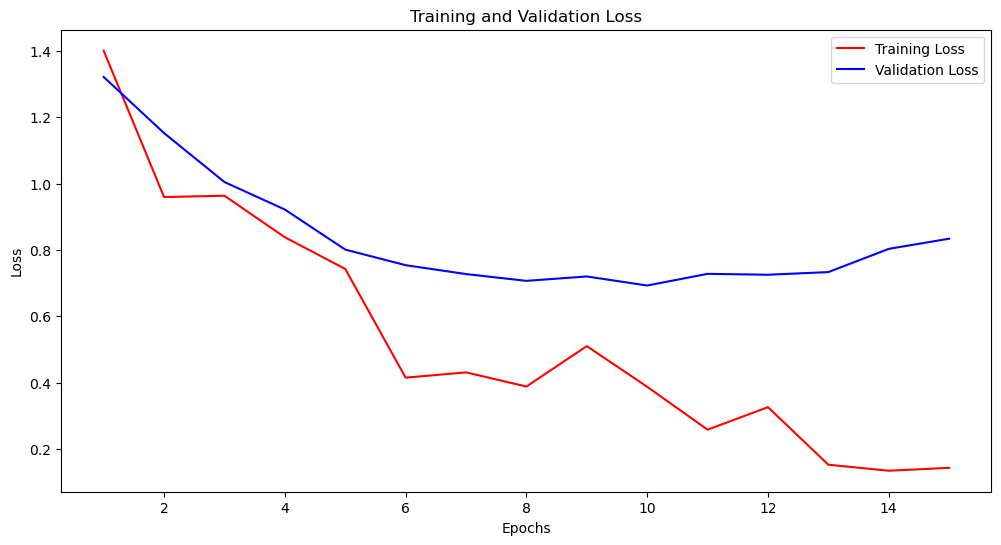

----------------------------------------------------------------------
Accuracy: 77.28
Precision: 76.30
Recall: 77.28
F1 Score: 76.71


In [28]:
hidden_dim = 128 # No. of neurons in each layer
num_layers = 4 # No. of hidden layers
model_LSTM = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.4).to(device)
lr = 0.002
early_stopping = True # Turnn on/off early stopping
lr_schedular = True # Turn on/off learning rate scheduler
num_epochs = 30
optimize = 2 # 1: SGD, 2: Adam, AdamW for any other number
print('Running LSTM model')
train_ES(model_LSTM, train_loader, val_loader, num_epochs, lr, early_stopping, lr_schedular, optimize)
# Note: After training is finished you must re-run the model definition for the one you used
print(70*'-')
lstm_metrics = {}
lstm_metrics['accuracy'], lstm_metrics['precision'], lstm_metrics['recall'], lstm_metrics['f1'] = evaluate_model(model_LSTM, val_loader)

Bi-LSTM

Running BiLSTM model
Using Early stopping...
Using Adam as optimizer...
Using Learning Rate Scheduler...
Starting training...
Epoch [1/30], Training Loss: 0.4052, Validation Loss: 0.7036
Epoch [2/30], Training Loss: 0.4192, Validation Loss: 0.6583
Epoch [3/30], Training Loss: 0.4061, Validation Loss: 0.6603
Epoch [4/30], Training Loss: 0.5984, Validation Loss: 0.6777
Epoch [5/30], Training Loss: 0.6227, Validation Loss: 0.6957
Epoch [6/30], Training Loss: 0.6715, Validation Loss: 0.7557
Epoch [7/30], Training Loss: 0.5631, Validation Loss: 0.8036
Terminated due to no validation improvement(Early stopping applied)


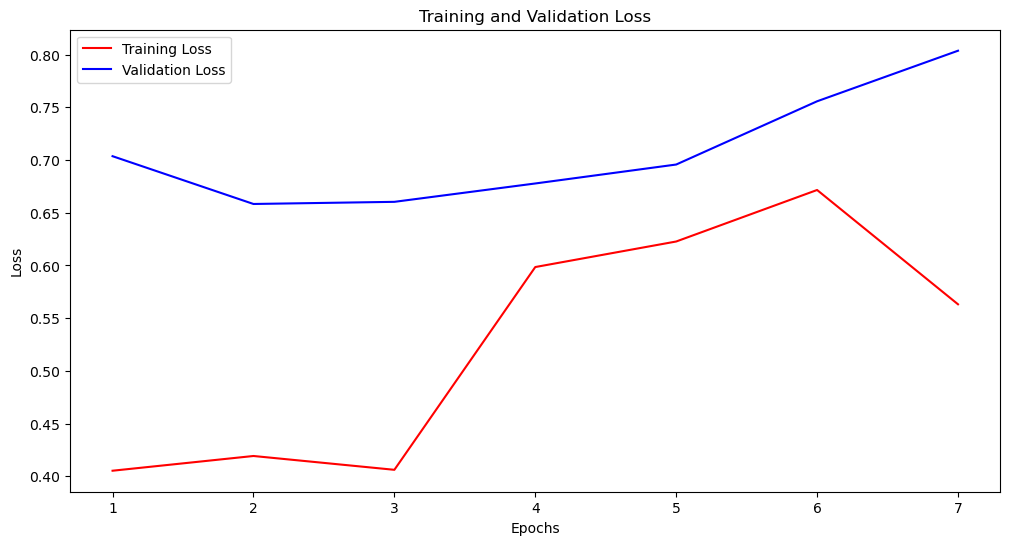

----------------------------------------------------------------------
Accuracy: 78.43
Precision: 77.72
Recall: 78.43
F1 Score: 77.96


In [29]:
hidden_dim = 128 # No. of neurons in each layer
num_layers = 4 # No. of hidden layers
model_BILSTM = BiLSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.4).to(device)
lr = 0.002
early_stopping = True # Turnn on/off early stopping
lr_schedular = True # Turn on/off learning rate scheduler
num_epochs = 30
optimize = 2 # 1: SGD, 2: Adam, AdamW for any other number
print('Running BiLSTM model')
train_ES(model_BILSTM, train_loader, val_loader, num_epochs, lr, early_stopping, lr_schedular, optimize)
# Note: After training is finished you must re-run the model definition for the one you used
print(70*'-')
bilstm_metrics = {}
bilstm_metrics['accuracy'], bilstm_metrics['precision'], bilstm_metrics['recall'], bilstm_metrics['f1'] = evaluate_model(model_BILSTM, val_loader)

GRU

Running GRU model
Using Early stopping...
Using Adam as optimizer...
Using Learning Rate Scheduler...
Starting training...
Epoch [1/30], Training Loss: 0.3934, Validation Loss: 0.7179
Epoch [2/30], Training Loss: 0.4808, Validation Loss: 0.6747
Epoch [3/30], Training Loss: 0.4178, Validation Loss: 0.6561
Epoch [4/30], Training Loss: 0.5424, Validation Loss: 0.6577
Epoch [5/30], Training Loss: 0.5736, Validation Loss: 0.6799
Epoch [6/30], Training Loss: 0.5899, Validation Loss: 0.7145
Epoch [7/30], Training Loss: 0.6277, Validation Loss: 0.7383
Epoch [8/30], Training Loss: 0.6059, Validation Loss: 0.7773
Terminated due to no validation improvement(Early stopping applied)


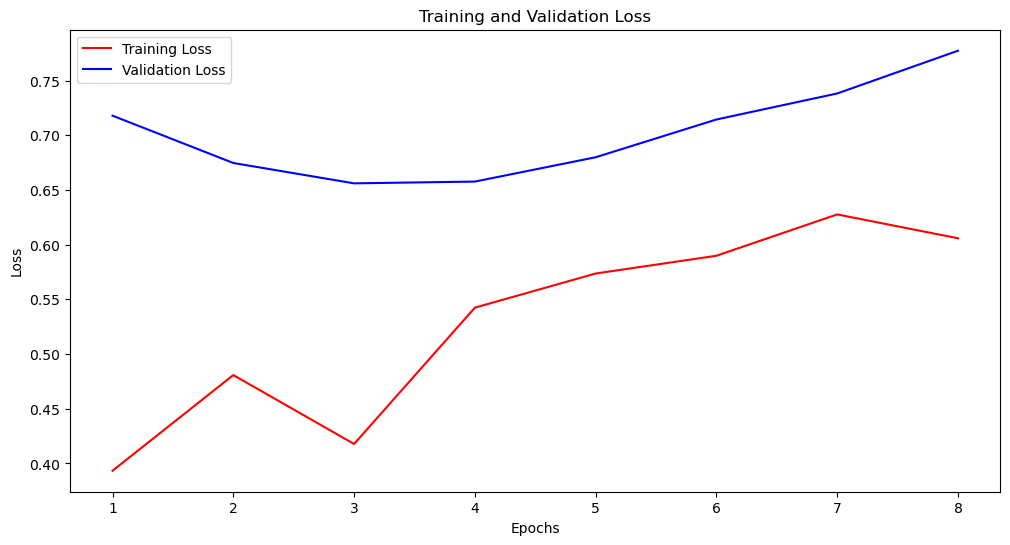

----------------------------------------------------------------------
Accuracy: 77.55
Precision: 76.79
Recall: 77.55
F1 Score: 77.06


In [30]:
hidden_dim = 128 # No. of neurons in each layer
num_layers = 4 # No. of hidden layers
model_GRU = GRUModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.3).to(device)
lr = 0.002
early_stopping = True # Turnn on/off early stopping
lr_schedular = True # Turn on/off learning rate scheduler
num_epochs = 30
optimize = 2 # 1: SGD, 2: Adam, AdamW for any other number
print('Running GRU model')
train_ES(model_GRU, train_loader, val_loader, num_epochs, lr, early_stopping, lr_schedular, optimize)
# Note: After training is finished you must re-run the model definition for the one you used
print(70*'-')
gru_metrics = {}
gru_metrics['accuracy'], gru_metrics['precision'], gru_metrics['recall'], gru_metrics['f1'] = evaluate_model(model_GRU, val_loader)

# Comparison

In [31]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots



# Create a list of model names
model_names = ['LSTM', 'BiLSTM', 'GRU']

# Create a list of metric values for each model
accuracy_values = [ lstm_metrics['accuracy'], bilstm_metrics['accuracy'], gru_metrics['accuracy']]
precision_values = [ lstm_metrics['precision'], bilstm_metrics['precision'], gru_metrics['precision']]
recall_values = [ lstm_metrics['recall'], bilstm_metrics['recall'], gru_metrics['recall']]
f1_values = [ lstm_metrics['f1'], bilstm_metrics['f1'], gru_metrics['f1']]

trace1 = go.Bar(x=model_names, y=accuracy_values, name='Accuracy')
trace2 = go.Bar(x=model_names, y=precision_values, name='Precision')
trace3 = go.Bar(x=model_names, y=recall_values, name='Recall')
trace4 = go.Bar(x=model_names, y=f1_values, name='F1-score')

# Create the figure and layout
fig = make_subplots(rows=1, cols=1)
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=1)
fig.add_trace(trace3, row=1, col=1)


# Update the layout
fig.update_layout(
    title='Comparison of Evaluation Metrics across Models',
    xaxis_title='Models',
    yaxis_title='Metric Values',
    barmode='group',
    legend=dict(
        x=1.05,
        y=1,
        traceorder='normal',
        bgcolor='rgba(0,0,0,0)',
        bordercolor='Black',
        borderwidth=2
    ),
    xaxis_type='category'
)

# Show the plot
fig.show()